In [ ]:
import os
import pandas as pd
import numpy as np
import re
import json
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# Set themes for seaborn and matplotlib
sns.set_theme(style="whitegrid", palette="colorblind")
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['figure.dpi'] = 120

In [ ]:
# Load config
with open('../configs/_default_configs.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Define paths
PROJECT_ROOT = Path(os.getcwd()).parent
DATA_DIR = PROJECT_ROOT / config['paths']['data_dir']
PROCESSED_DATA_DIR = PROJECT_ROOT / config['paths']['processed_data_dir']
NOTEBOOKS_DIR = PROJECT_ROOT / config['paths']['notebooks_dir']
MODEL_DIR = PROJECT_ROOT / config['paths']['model_dir']

# Define dataset paths
BNT_PATH= DATA_DIR / 'BNT-syntheticData_v2.xlsx'
FAS_PATH = DATA_DIR / 'FAS-syntheticData_v1.xlsx'
SVF_PATH = DATA_DIR / 'SVF-syntheticData_v1.xlsx'

In [12]:

bnt_raw = pd.read_excel(BNT_PATH)
svf_raw = pd.read_excel(SVF_PATH)
fas_raw = pd.read_excel(FAS_PATH)
print(f"BNT raw shape: {bnt_raw.shape}")
print(f"SVF raw shape: {svf_raw.shape}")
print(f"FAS raw shape: {fas_raw.shape}")

BNT raw shape: (35, 102)
SVF raw shape: (29, 101)
FAS raw shape: (20, 101)


In [13]:
# Separate metadata from response data
def extract_metadata(df, gold_col=None):
    """Extract Gender, Age, Category rows from the bottom of a dataframe."""
    # Find metadata rows by checking first column for 'Gender:', 'Age:', 'Category:'/'Kategori:'
    first_col = df.iloc[:, 0].astype(str)
    meta_mask = first_col.str.contains(r'^(?:Gender|Age|Categor|Kategori)', na=False)
    meta_rows = df[meta_mask]
    data_rows = df[~meta_mask]

    # Build metadata dict
    meta = {}
    user_cols = [c for c in df.columns if str(c).startswith('User')]
    for _, row in meta_rows.iterrows():
        key = str(row.iloc[0]).rstrip(':').strip()
        if key in ('Kategori',):
            key = 'Category'
        meta[key] = row[user_cols].values

    meta_df = pd.DataFrame(meta, index=user_cols)
    meta_df['Age'] = pd.to_numeric(meta_df['Age'], errors='coerce')
    return data_rows, meta_df

bnt_data, bnt_meta = extract_metadata(bnt_raw)
svf_data, svf_meta = extract_metadata(svf_raw)
fas_data, fas_meta = extract_metadata(fas_raw)

### Cleaning

In [15]:
# Clean BNT: set gold column and drop empty rows
bnt_data = bnt_data.dropna(how='all', subset=[c for c in bnt_data.columns if str(c).startswith('User')])
bnt_gold = bnt_data.iloc[:, 0].values  # target words
bnt_user_cols = [c for c in bnt_data.columns if str(c).startswith('User')]
bnt_responses = bnt_data[bnt_user_cols]
bnt_responses.index = bnt_gold

# Clean SVF: drop empty rows
svf_user_cols = [c for c in svf_data.columns if str(c).startswith('User')]
svf_responses = svf_data[svf_user_cols].dropna(how='all')
svf_responses.index = range(1, len(svf_responses) + 1)
svf_responses.index.name = 'response_slot'

# Clean FAS: drop empty rows
fas_user_cols = [c for c in fas_data.columns if str(c).startswith('User')]
fas_responses = fas_data[fas_user_cols].dropna(how='all')
fas_responses.index = range(1, len(fas_responses) + 1)
fas_responses.index.name = 'response_slot'

print(f"BNT: {len(bnt_gold)} items × {len(bnt_user_cols)} users")
print(f"SVF: up to {len(svf_responses)} response slots × {len(svf_user_cols)} users")
print(f"FAS: up to {len(fas_responses)} response slots × {len(fas_user_cols)} users")


BNT: 30 items × 100 users
SVF: up to 25 response slots × 100 users
FAS: up to 16 response slots × 100 users


### Explore demographics


  BNT — Demographics (n=100)

Diagnostic category:
       MCI:  30  (30.0%)
    non-AD:  26  (26.0%)
        HC:  25  (25.0%)
        AD:  19  (19.0%)

Gender:
         F:  58  (58.0%)
         M:  42  (42.0%)

Age: mean=65.4, sd=5.7, range=[55.2, 80.0]

Age by category:
        AD: mean=65.6, sd=5.8, n=19
        HC: mean=65.8, sd=6.2, n=25
       MCI: mean=66.1, sd=6.2, n=30
    non-AD: mean=64.2, sd=4.4, n=26

  SVF — Demographics (n=100)

Diagnostic category:
       MCI:  33  (33.0%)
        HC:  28  (28.0%)
        AD:  20  (20.0%)
    non-AD:  19  (19.0%)

Gender:
         M:  52  (52.0%)
         F:  48  (48.0%)

Age: mean=67.8, sd=6.8, range=[55.3, 79.8]

Age by category:
        AD: mean=66.9, sd=6.5, n=20
        HC: mean=69.2, sd=6.7, n=28
       MCI: mean=68.1, sd=7.5, n=33
    non-AD: mean=66.2, sd=6.3, n=19

  FAS — Demographics (n=100)

Diagnostic category:
        AD:  30  (30.0%)
    non-AD:  26  (26.0%)
       MCI:  23  (23.0%)
        HC:  21  (21.0%)

Gender:
     

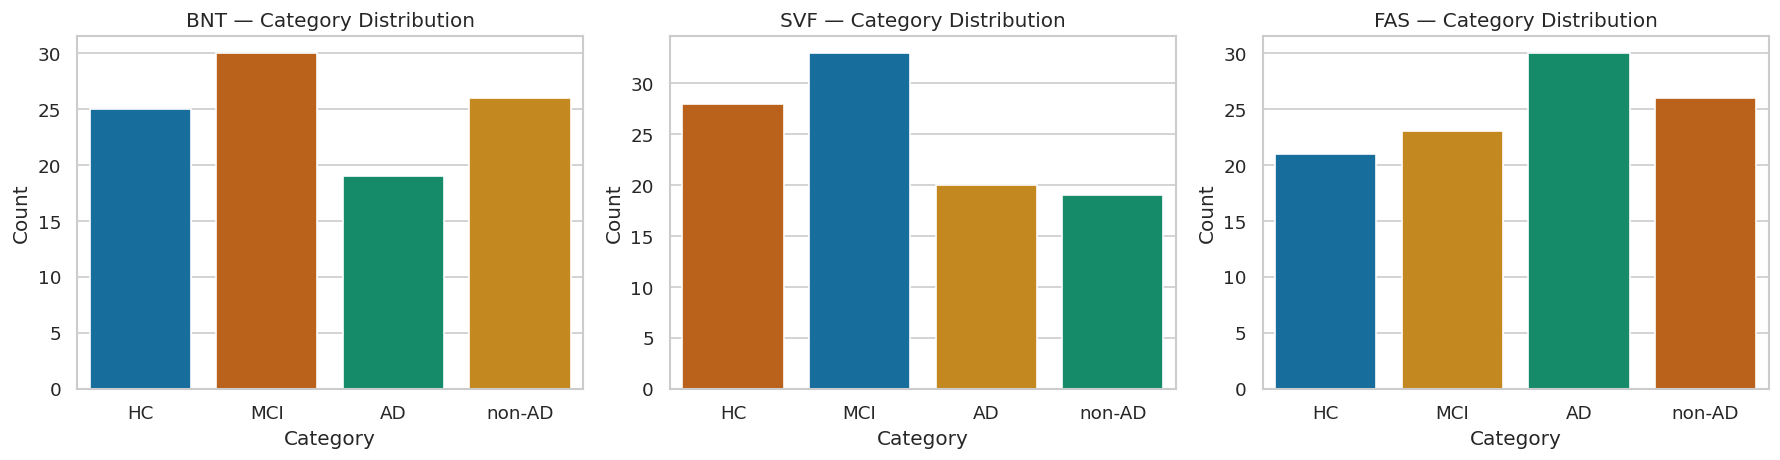

In [16]:
def summarize_demographics(meta_df, test_name):
    print(f"\n{'='*50}")
    print(f"  {test_name} — Demographics (n={len(meta_df)})")
    print(f"{'='*50}")

    # Category distribution
    print(f"\nDiagnostic category:")
    cat_counts = meta_df['Category'].value_counts()
    for cat, n in cat_counts.items():
        print(f"  {cat:>8s}: {n:3d}  ({100*n/len(meta_df):.1f}%)")

    # Gender
    print(f"\nGender:")
    gen_counts = meta_df['Gender'].value_counts()
    for g, n in gen_counts.items():
        print(f"  {g:>8s}: {n:3d}  ({100*n/len(meta_df):.1f}%)")

    # Age
    ages = meta_df['Age'].dropna()
    print(f"\nAge: mean={ages.mean():.1f}, sd={ages.std():.1f}, "
          f"range=[{ages.min():.1f}, {ages.max():.1f}]")

    # Age by category
    print(f"\nAge by category:")
    for cat in sorted(meta_df['Category'].dropna().unique()):
        a = meta_df.loc[meta_df['Category'] == cat, 'Age'].dropna()
        print(f"  {cat:>8s}: mean={a.mean():.1f}, sd={a.std():.1f}, n={len(a)}")

for name, meta in [('BNT', bnt_meta), ('SVF', svf_meta), ('FAS', fas_meta)]:
    summarize_demographics(meta, name)

# %%
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, meta) in zip(axes, [('BNT', bnt_meta), ('SVF', svf_meta), ('FAS', fas_meta)]):
    cat_order = ['HC', 'MCI', 'AD', 'non-AD']
    cats = [c for c in cat_order if c in meta['Category'].values]
    sns.countplot(data=meta, x='Category', order=cats, ax=ax, hue='Category', legend=False)
    ax.set_title(f'{name} — Category Distribution')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

### BNT: Exploring the data

In [18]:
# --- 3a. Missing / empty / special responses ---
def classify_bnt_response(resp, gold):
    """Classify a BNT response into types."""
    if pd.isna(resp) or str(resp).strip() == '':
        return 'empty'
    resp = str(resp).strip().lower()
    if resp == 'pass':
        return 'pass'
    if resp == 'sak':  # generic non-answer
        return 'generic_nonword'
    # Exact match (ignoring articles like "en", "ett")
    cleaned = re.sub(r'^(en|ett)\s+', '', resp)
    if cleaned == gold.lower():
        return 'correct'
    # Contains gold word
    if gold.lower() in resp:
        return 'contains_target'
    return 'other_response'

# Build classification matrix
bnt_classes = pd.DataFrame(index=bnt_gold, columns=bnt_user_cols)
for item in bnt_gold:
    for user in bnt_user_cols:
        bnt_classes.loc[item, user] = classify_bnt_response(
            bnt_responses.loc[item, user], item
        )

print("BNT Response Classification (all items × all users):")
total = bnt_classes.size
for rtype in ['correct', 'contains_target', 'other_response', 'pass', 'generic_nonword', 'empty']:
    n = (bnt_classes == rtype).sum().sum()
    print(f"  {rtype:>20s}: {n:5d}  ({100*n/total:.1f}%)")

BNT Response Classification (all items × all users):
               correct:  1401  (46.7%)
       contains_target:   612  (20.4%)
        other_response:   923  (30.8%)
                  pass:    52  (1.7%)
       generic_nonword:    12  (0.4%)
                 empty:     0  (0.0%)


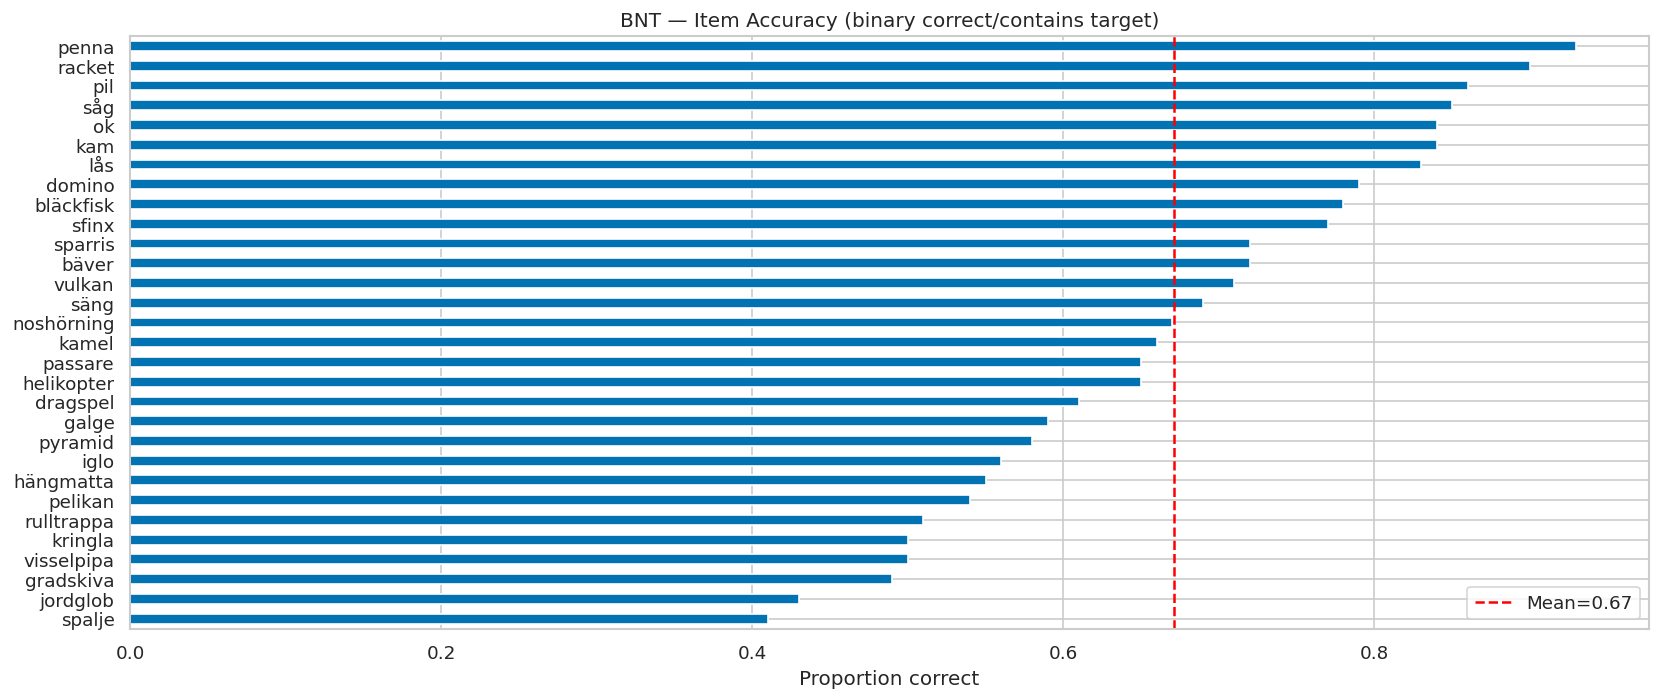

In [19]:
# --- 3b. Accuracy per item (binary: correct or contains_target) ---
bnt_correct = bnt_classes.isin(['correct', 'contains_target'])
item_accuracy = bnt_correct.mean(axis=1).sort_values()

fig, ax = plt.subplots(figsize=(14, 6))
item_accuracy.plot(kind='barh', ax=ax, color=sns.color_palette('colorblind')[0])
ax.set_xlabel('Proportion correct')
ax.set_title('BNT — Item Accuracy (binary correct/contains target)')
ax.axvline(x=item_accuracy.mean(), color='red', linestyle='--', label=f'Mean={item_accuracy.mean():.2f}')
ax.legend()
plt.tight_layout()
plt.show()

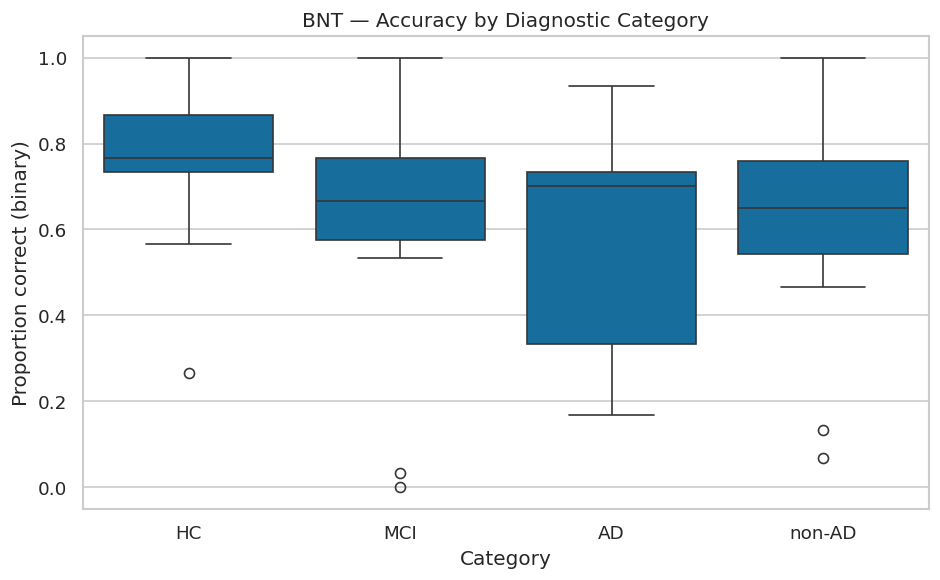


BNT accuracy by category:
        HC: mean=0.777, sd=0.149, n=25
       MCI: mean=0.663, sd=0.219, n=30
        AD: mean=0.579, sd=0.237, n=19
    non-AD: mean=0.645, sd=0.224, n=26


In [ ]:
# --- 3c. Accuracy by diagnostic category ---
bnt_acc_by_cat = {}
for user in bnt_user_cols:
    cat = bnt_meta.loc[user, 'Category']
    acc = bnt_correct[user].mean()
    bnt_acc_by_cat.setdefault(cat, []).append(acc)

bnt_cat_df = pd.DataFrame([
    {'Category': cat, 'Accuracy': acc}
    for cat, accs in bnt_acc_by_cat.items()
    for acc in accs
])

fig, ax = plt.subplots(figsize=(8, 5))
cat_order = ['HC', 'MCI', 'AD', 'non-AD']
sns.boxplot(data=bnt_cat_df, x='Category', y='Accuracy', order=cat_order, ax=ax)
ax.set_title('BNT — Accuracy by Diagnostic Category')
ax.set_ylabel('Proportion correct (binary)')
plt.tight_layout()
plt.show()

print("\nBNT accuracy by category:")
for cat in cat_order:
    vals = bnt_cat_df.loc[bnt_cat_df['Category'] == cat, 'Accuracy']
    if len(vals) > 0:
        print(f"  {cat:>8s}: mean={vals.mean():.3f}, sd={vals.std():.3f}, n={len(vals)}")

# %%

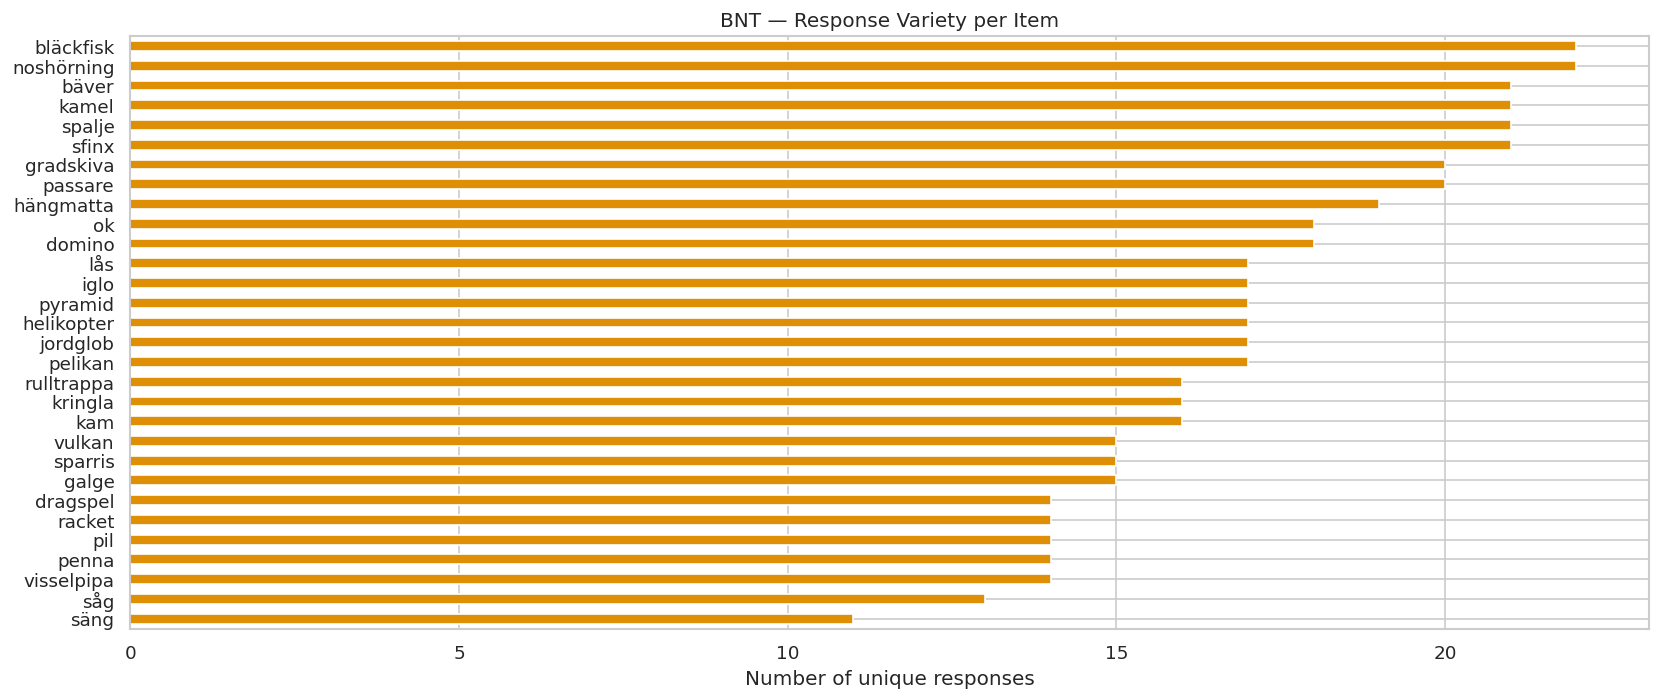


Most diverse items (top 5):
  bläckfisk: 22 unique responses
  noshörning: 22 unique responses
  spalje: 21 unique responses
  sfinx: 21 unique responses
  bäver: 21 unique responses


In [21]:
# --- 3d. Response variety per item ---
def unique_responses_per_item(responses_df):
    """Count unique non-empty responses per item."""
    result = {}
    for item in responses_df.index:
        resps = responses_df.loc[item].dropna().astype(str)
        resps = resps[resps.str.strip() != '']
        cleaned = resps.str.strip().str.lower()
        result[item] = cleaned.nunique()
    return pd.Series(result)

bnt_variety = unique_responses_per_item(bnt_responses)

fig, ax = plt.subplots(figsize=(14, 6))
bnt_variety.sort_values().plot(kind='barh', ax=ax, color=sns.color_palette('colorblind')[1])
ax.set_xlabel('Number of unique responses')
ax.set_title('BNT — Response Variety per Item')
plt.tight_layout()
plt.show()

print(f"\nMost diverse items (top 5):")
for item, n in bnt_variety.sort_values(ascending=False).head(5).items():
    print(f"  {item}: {n} unique responses")

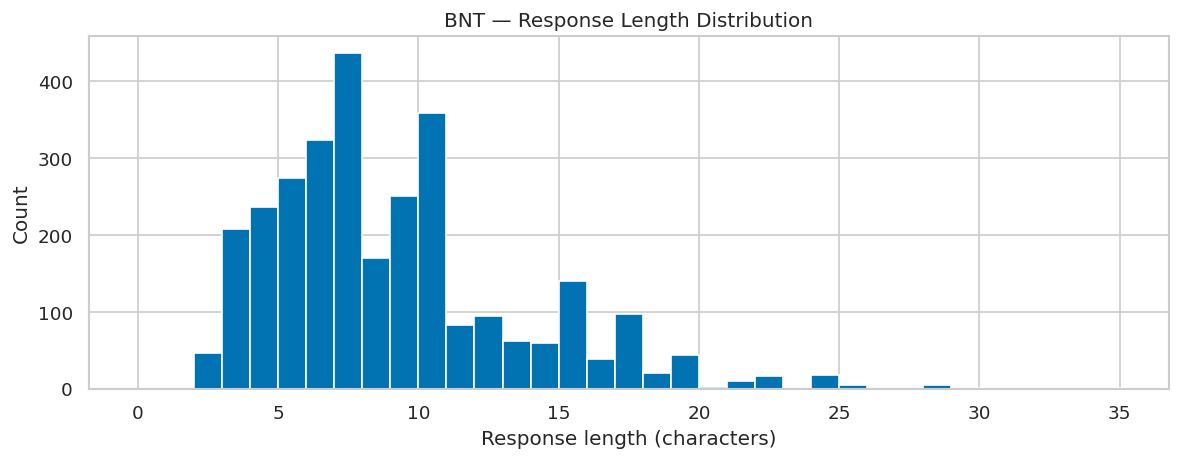

Response length: mean=8.6, median=7, max=34
BNT — Most common non-target responses per item:
             säng → "bädd" (19), "bäddad säng" (10), "sovplats" (7)
            penna → "skrivpenna" (29), "kulspetspenna" (13), "blyertspenna" (8)
       visselpipa → "pipa" (15), "domarpipa" (14), "signalpipa" (11)
              kam → "hårkam" (25), "kam hår" (8), "något sånt" (4)
              såg → "handsåg" (26), "träsåg" (7), "verktyg" (4)
       helikopter → "rotorflyg" (13), "räddningshelikopter" (12), "flygmaskin" (10)
        bläckfisk → "åttaarmad bläckfisk" (13), "havsdjur bläckfisk" (9), "havsdjur" (4)
            galge → "klädhängare" (19), "klädgalge" (17), "hängare" (7)
            kamel → "puckelkamel" (13), "dromedar" (9), "ökendjur" (6)
          kringla → "bakverk" (27), "kaka" (8), "pretzel" (4)
           racket → "badmintonracket" (23), "tennisracket" (21), "hhhm jag vet inte" (2)
           vulkan → "eldberg" (16), "vulkanutbrott" (10), "jag tror vulkanutbrott" (4)
     

In [22]:
# --- 3e. Response length (character count) distribution ---
bnt_lengths = bnt_responses.stack().dropna().astype(str).str.len()

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(bnt_lengths, bins=range(0, bnt_lengths.max() + 2), edgecolor='white')
ax.set_xlabel('Response length (characters)')
ax.set_ylabel('Count')
ax.set_title('BNT — Response Length Distribution')
plt.tight_layout()
plt.show()

print(f"Response length: mean={bnt_lengths.mean():.1f}, median={bnt_lengths.median():.0f}, "
      f"max={bnt_lengths.max()}")

# %%
# --- 3f. Most common paraphasic responses per item ---
print("BNT — Most common non-target responses per item:")
print("=" * 60)
for item in bnt_gold:
    resps = bnt_responses.loc[item].dropna().astype(str).str.strip().str.lower()
    resps = resps[resps != '']
    # Remove exact matches
    gold_clean = item.lower()
    non_target = resps[~resps.apply(lambda x: re.sub(r'^(en|ett)\s+', '', x) == gold_clean)]
    if len(non_target) > 0:
        top = Counter(non_target).most_common(3)
        top_str = ', '.join([f'"{w}" ({n})' for w, n in top])
        print(f"  {item:>15s} → {top_str}")


## 4. SVF — Exploratory Analysis

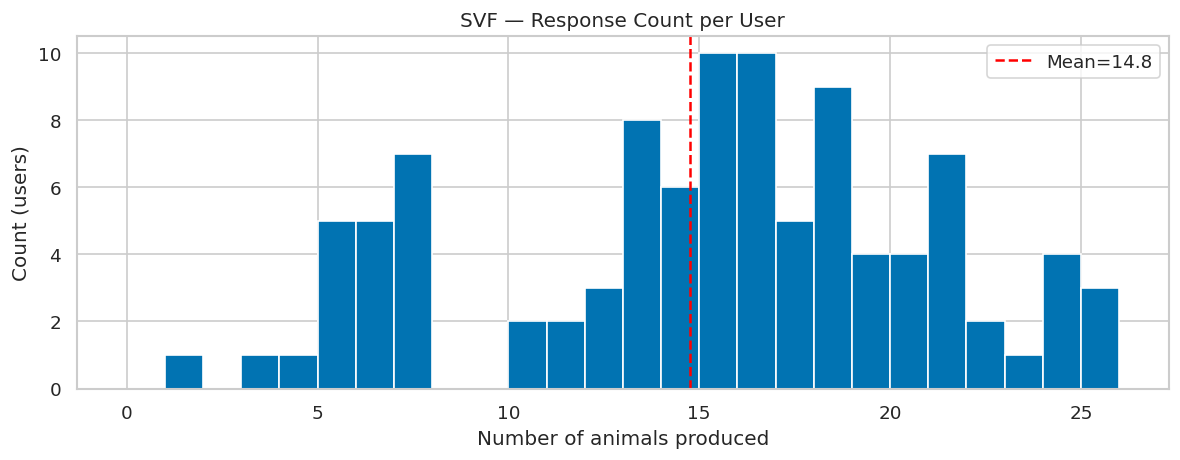

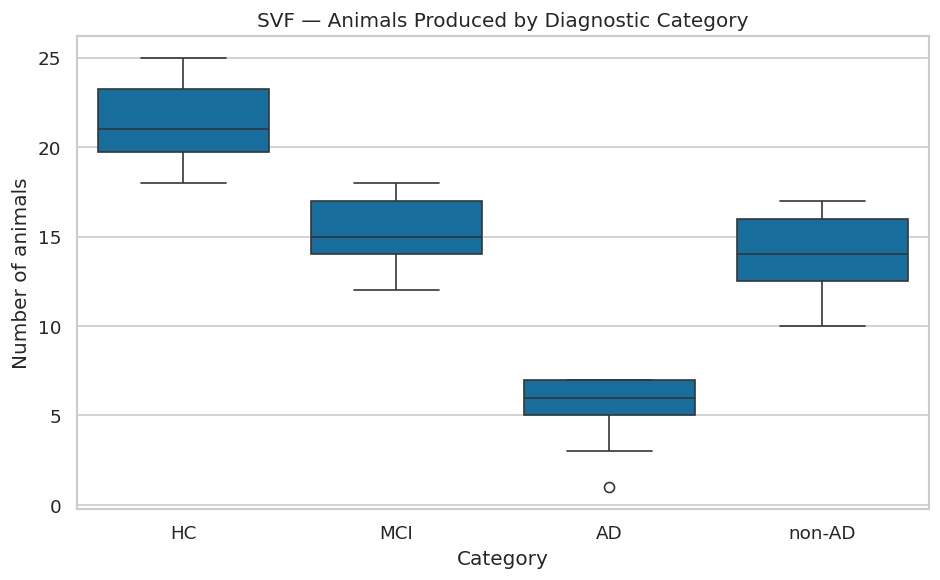


SVF response counts by category:
        HC: mean=21.2, sd=2.2, n=28
       MCI: mean=15.4, sd=1.9, n=33
        AD: mean=5.6, sd=1.6, n=20
    non-AD: mean=13.8, sd=2.2, n=19


In [24]:
svf_counts = svf_responses.apply(lambda col: col.dropna().astype(str).str.strip().ne('').sum())

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(svf_counts, bins=range(0, svf_counts.max() + 2), edgecolor='white')
ax.set_xlabel('Number of animals produced')
ax.set_ylabel('Count (users)')
ax.set_title('SVF — Response Count per User')
ax.axvline(x=svf_counts.mean(), color='red', linestyle='--', label=f'Mean={svf_counts.mean():.1f}')
ax.legend()
plt.tight_layout()
plt.show()

# %%
# --- 4b. Response count by diagnostic category ---
svf_count_cat = pd.DataFrame({
    'count': svf_counts,
    'Category': [svf_meta.loc[u, 'Category'] for u in svf_user_cols]
})

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=svf_count_cat, x='Category', y='count', order=['HC', 'MCI', 'AD', 'non-AD'], ax=ax)
ax.set_title('SVF — Animals Produced by Diagnostic Category')
ax.set_ylabel('Number of animals')
plt.tight_layout()
plt.show()

print("\nSVF response counts by category:")
for cat in ['HC', 'MCI', 'AD', 'non-AD']:
    vals = svf_count_cat.loc[svf_count_cat['Category'] == cat, 'count']
    if len(vals) > 0:
        print(f"  {cat:>8s}: mean={vals.mean():.1f}, sd={vals.std():.1f}, n={len(vals)}")

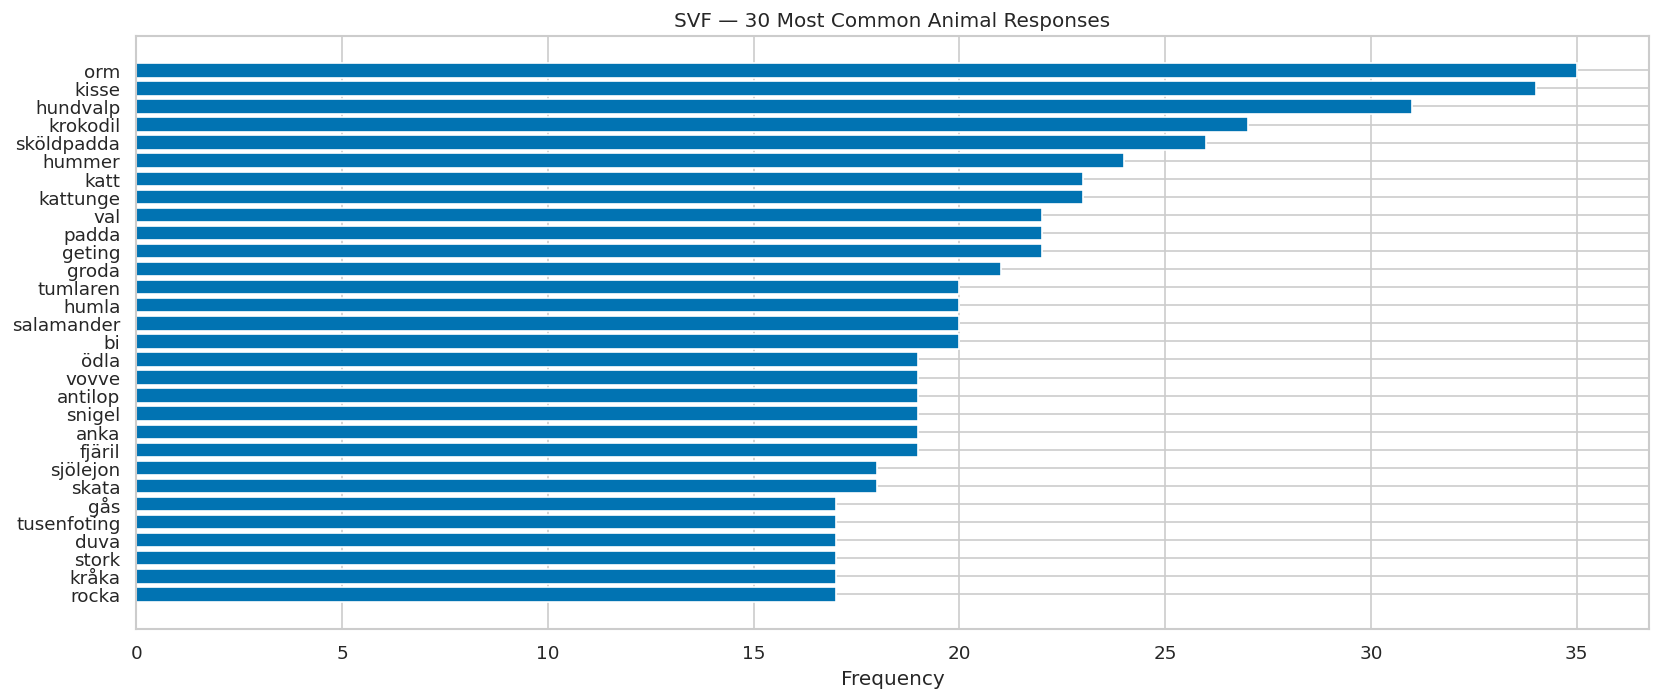

Total unique animal tokens: 122


In [25]:
# --- 4c. Most common animals & frequency distribution ---
all_svf = svf_responses.stack().dropna().astype(str).str.strip().str.lower()
all_svf = all_svf[all_svf != '']

# Clean: remove leading "och ", "eee ", "ja vet inte", "kanske en "
all_svf_clean = all_svf.str.replace(r'^(och|eee|kanske en?)\s+', '', regex=True)

animal_counts = Counter(all_svf_clean)
top_animals = animal_counts.most_common(30)

fig, ax = plt.subplots(figsize=(14, 6))
animals, counts = zip(*top_animals)
ax.barh(range(len(animals)), counts)
ax.set_yticks(range(len(animals)))
ax.set_yticklabels(animals)
ax.set_xlabel('Frequency')
ax.set_title('SVF — 30 Most Common Animal Responses')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(f"Total unique animal tokens: {len(animal_counts)}")

In [ ]:
# --- 4d. Detect potential non-animal intrusions ---
# Flag responses that appear very rarely (potential errors or intrusions)
rare_threshold = 2
rare_animals = {word for word, count in animal_counts.items() if count <= rare_threshold}
print(f"Rare responses (≤{rare_threshold} occurrences) — potential intrusions or errors:")
for word in sorted(rare_animals):
    print(f"  '{word}' ({animal_counts[word]})")

# %%
# --- 4e. Repetitions within a user's response list ---
svf_repetitions = {}
for user in svf_user_cols:
    resps = svf_responses[user].dropna().astype(str).str.strip().str.lower()
    resps = resps[resps != '']
    counts = Counter(resps)
    reps = {word: n for word, n in counts.items() if n > 1}
    if reps:
        svf_repetitions[user] = reps

print(f"Users with repeated animals: {len(svf_repetitions)} / {len(svf_user_cols)}")
if svf_repetitions:
    print("Examples:")
    for user, reps in list(svf_repetitions.items())[:5]:
        cat = svf_meta.loc[user, 'Category']
        print(f"  {user} ({cat}): {reps}")

## 5. FAS — Exploratory Analysis

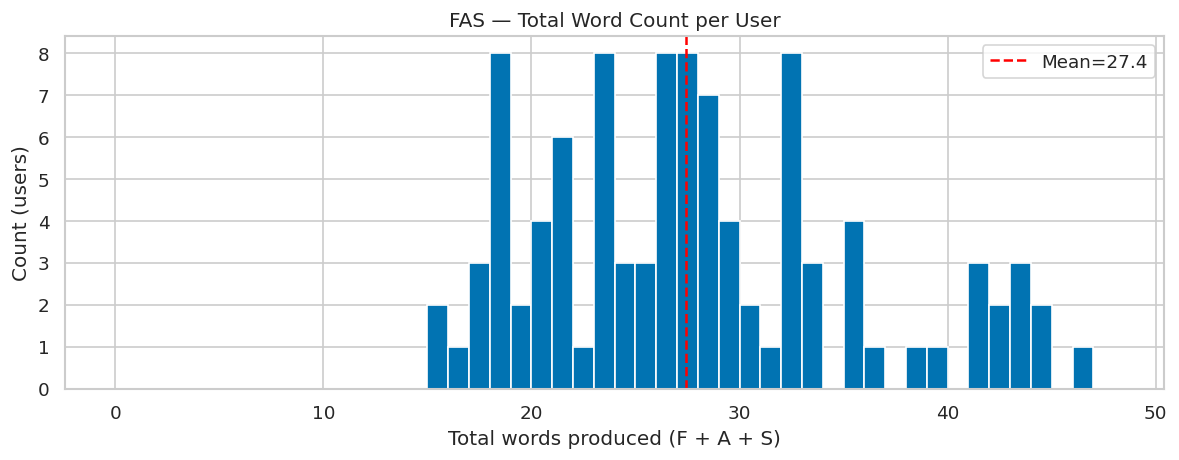

In [26]:
# --- 5a. Parse FAS responses (each cell = "F-word, A-word, S-word") ---
def parse_fas_cell(cell):
    """Parse a FAS cell into individual words for F, A, S."""
    if pd.isna(cell) or str(cell).strip() == '':
        return []
    parts = [p.strip() for p in str(cell).split(',')]
    return [p for p in parts if p != '']

# Count total words per user
fas_word_counts = {}
fas_by_letter = {'F': [], 'A': [], 'S': []}

for user in fas_user_cols:
    total = 0
    f_words, a_words, s_words = [], [], []
    for slot in fas_responses.index:
        cell = fas_responses.loc[slot, user]
        parts = parse_fas_cell(cell)
        total += len(parts)
        if len(parts) >= 1:
            f_words.append(parts[0])
        if len(parts) >= 2:
            a_words.append(parts[1])
        if len(parts) >= 3:
            s_words.append(parts[2])
    fas_word_counts[user] = {
        'total': total,
        'F': len(f_words),
        'A': len(a_words),
        'S': len(s_words),
        'F_words': f_words,
        'A_words': a_words,
        'S_words': s_words,
    }

fas_totals = pd.DataFrame({u: {k: v for k, v in d.items() if k in ('total', 'F', 'A', 'S')}
                            for u, d in fas_word_counts.items()}).T

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(fas_totals['total'], bins=range(0, fas_totals['total'].max() + 3), edgecolor='white')
ax.set_xlabel('Total words produced (F + A + S)')
ax.set_ylabel('Count (users)')
ax.set_title('FAS — Total Word Count per User')
ax.axvline(x=fas_totals['total'].mean(), color='red', linestyle='--',
           label=f'Mean={fas_totals["total"].mean():.1f}')
ax.legend()
plt.tight_layout()
plt.show()

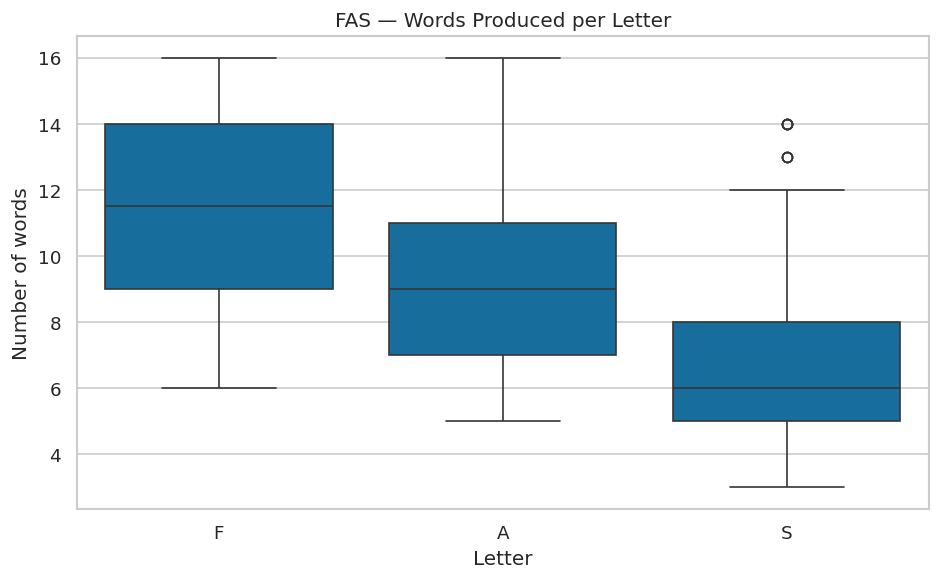

Words per letter:
  F: mean=11.5, sd=2.7
  A: mean=9.0, sd=2.8
  S: mean=6.9, sd=2.9


In [27]:
fig, ax = plt.subplots(figsize=(8, 5))
fas_letter_melted = fas_totals[['F', 'A', 'S']].melt(var_name='Letter', value_name='Count')
sns.boxplot(data=fas_letter_melted, x='Letter', y='Count', ax=ax)
ax.set_title('FAS — Words Produced per Letter')
ax.set_ylabel('Number of words')
plt.tight_layout()
plt.show()

print("Words per letter:")
for letter in ['F', 'A', 'S']:
    vals = fas_totals[letter]
    print(f"  {letter}: mean={vals.mean():.1f}, sd={vals.std():.1f}")

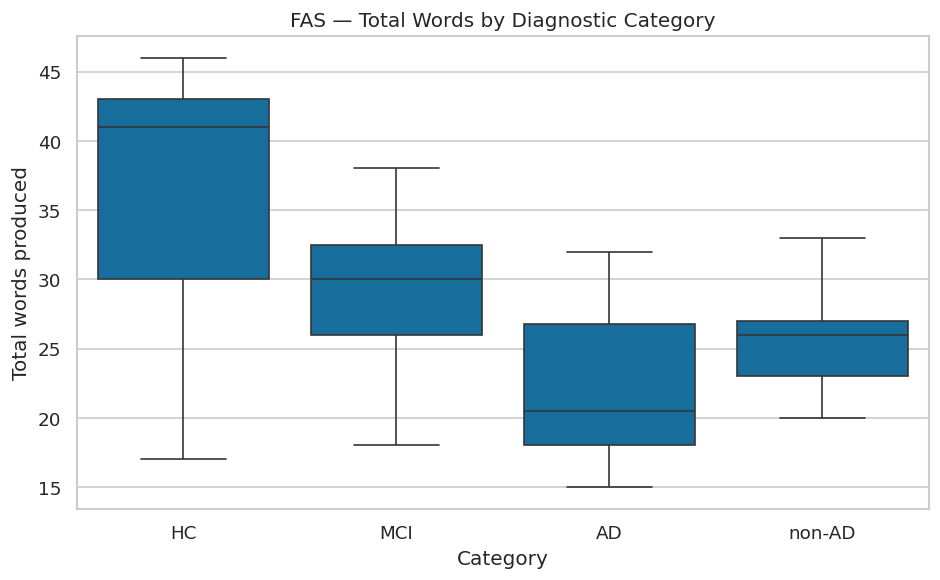


FAS total words by category:
        HC: mean=35.8, sd=9.1, n=21
       MCI: mean=29.2, sd=5.4, n=23
        AD: mean=21.8, sd=4.9, n=30
    non-AD: mean=25.6, sd=3.1, n=26


In [28]:
# --- 5c. FAS by diagnostic category ---
fas_totals['Category'] = [fas_meta.loc[u, 'Category'] if u in fas_meta.index else 'Unknown'
                          for u in fas_totals.index]

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=fas_totals, x='Category', y='total',
            order=['HC', 'MCI', 'AD', 'non-AD'], ax=ax)
ax.set_title('FAS — Total Words by Diagnostic Category')
ax.set_ylabel('Total words produced')
plt.tight_layout()
plt.show()

print("\nFAS total words by category:")
for cat in ['HC', 'MCI', 'AD', 'non-AD']:
    vals = fas_totals.loc[fas_totals['Category'] == cat, 'total']
    if len(vals) > 0:
        print(f"  {cat:>8s}: mean={vals.mean():.1f}, sd={vals.std():.1f}, n={len(vals)}")

In [29]:
# --- 5d. Detect proper nouns / intrusions (marked with <>) ---
print("FAS — Responses containing proper nouns (angle-bracket markers):")
for user in fas_user_cols:
    for slot in fas_responses.index:
        cell = str(fas_responses.loc[slot, user])
        if '<' in cell and '>' in cell:
            cat = fas_meta.loc[user, 'Category'] if user in fas_meta.index else '?'
            proper_nouns = re.findall(r'<([^>]+)>', cell)
            print(f"  {user} ({cat}), slot {slot}: {proper_nouns} — full: \"{cell.strip()}\"")

FAS — Responses containing proper nouns (angle-bracket markers):
  User-1 (HC), slot 2: ['Anna'] — full: "fart, <Anna>, spår"
  User-1 (HC), slot 9: ['Stockholm'] — full: "frost, ansikte, <Stockholm>"
  User-2 (MCI), slot 2: ['Fredrik'] — full: "<Fredrik>, antal, sorg"
  User-2 (MCI), slot 7: ['Anna'] — full: "filt, <Anna>, sarek"
  User-5 (HC), slot 8: ['Stockholm'] — full: "flamma, avtryck, <Stockholm>"
  User-5 (HC), slot 10: ['Anna'] — full: "fabrik, <Anna>, snö"
  User-6 (MCI), slot 2: ['Stockholm'] — full: "förtroende, andel, <Stockholm>"
  User-7 (MCI), slot 8: ['Stockholm'] — full: "frekvens, afton, <Stockholm>"
  User-9 (AD), slot 8: ['Stockholm'] — full: ", , <Stockholm>"
  User-11 (HC), slot 8: ['Anton'] — full: "frekvens, <Anton>, sarek"
  User-12 (non-AD), slot 3: ['Stockholm'] — full: "fana, avtryck, <Stockholm>"
  User-13 (non-AD), slot 3: ['Anna'] — full: "fobi, <Anna>, skog"
  User-14 (MCI), slot 1: ['Stockholm'] — full: "fäste, arbete, <Stockholm>"
  User-14 (MCI), sl

In [30]:
# --- 5e. Empty/missing cells in FAS ---
fas_empty = fas_responses.isna() | (fas_responses.astype(str).apply(lambda x: x.str.strip() == ''))
fas_empty_per_user = fas_empty.sum(axis=0)

# Also check for partial cells (missing one of F, A, S)
fas_partial = 0
for user in fas_user_cols:
    for slot in fas_responses.index:
        parts = parse_fas_cell(fas_responses.loc[slot, user])
        if 0 < len(parts) < 3:
            fas_partial += 1

print(f"FAS missing/empty cells: {fas_empty.sum().sum()} out of {fas_empty.size}")
print(f"FAS partial cells (1-2 words instead of 3): {fas_partial}")


FAS missing/empty cells: 448 out of 1600
FAS partial cells (1-2 words instead of 3): 461


## 6. Cross-Test Comparison

Users present in all three tests: 98

Pearson correlations between test scores:
              BNT_accuracy  SVF_count  FAS_total    Age
BNT_accuracy         1.000      0.061      0.092 -0.101
SVF_count            0.061      1.000      0.076  0.031
FAS_total            0.092      0.076      1.000  0.023
Age                 -0.101      0.031      0.023  1.000


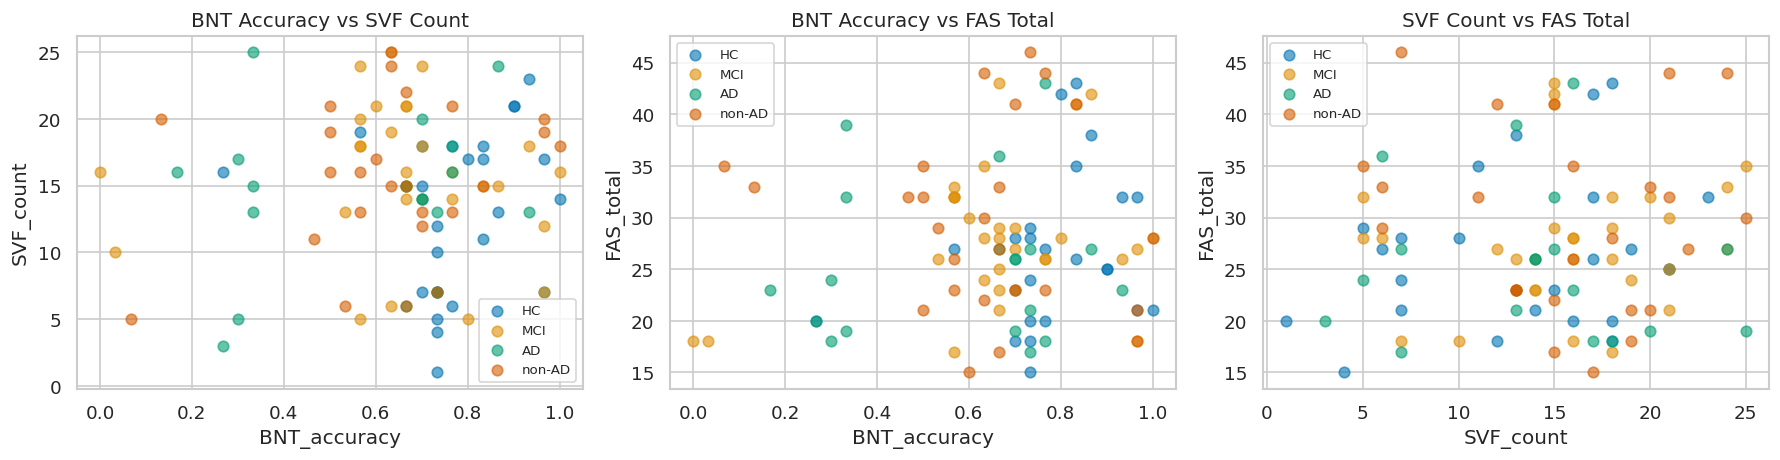

In [32]:
# --- Combine per-user metrics across tests ---
# Only for users that appear in all three datasets
common_users = sorted(set(bnt_user_cols) & set(svf_user_cols) & set(fas_user_cols))
print(f"Users present in all three tests: {len(common_users)}")

cross_df = pd.DataFrame(index=common_users)
cross_df['BNT_accuracy'] = [bnt_correct[u].mean() for u in common_users]
cross_df['SVF_count'] = [svf_counts.get(u, np.nan) for u in common_users]
cross_df['FAS_total'] = [fas_totals.loc[u, 'total'] if u in fas_totals.index else np.nan
                          for u in common_users]
cross_df['Category'] = [bnt_meta.loc[u, 'Category'] for u in common_users]
cross_df['Age'] = [bnt_meta.loc[u, 'Age'] for u in common_users]

# Correlation matrix
print("\nPearson correlations between test scores:")
print(cross_df[['BNT_accuracy', 'SVF_count', 'FAS_total', 'Age']].corr().round(3))

# %%
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

pairs = [('BNT_accuracy', 'SVF_count'), ('BNT_accuracy', 'FAS_total'), ('SVF_count', 'FAS_total')]
for ax, (x, y) in zip(axes, pairs):
    for cat in ['HC', 'MCI', 'AD', 'non-AD']:
        subset = cross_df[cross_df['Category'] == cat]
        ax.scatter(subset[x], subset[y], label=cat, alpha=0.6, s=40)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.legend(fontsize=8)

axes[0].set_title('BNT Accuracy vs SVF Count')
axes[1].set_title('BNT Accuracy vs FAS Total')
axes[2].set_title('SVF Count vs FAS Total')
plt.tight_layout()
plt.show()

## 7. Summary Statistics Table

In [33]:
summary = pd.DataFrame({
    'Test': ['BNT', 'SVF', 'FAS'],
    'N_users': [len(bnt_user_cols), len(svf_user_cols), len(fas_user_cols)],
    'N_items_or_slots': [len(bnt_gold), len(svf_responses), len(fas_responses)],
    'Total_responses': [
        bnt_responses.stack().dropna().astype(str).str.strip().ne('').sum(),
        svf_responses.stack().dropna().astype(str).str.strip().ne('').sum(),
        fas_responses.stack().dropna().astype(str).str.strip().ne('').sum(),
    ],
    'Unique_responses': [
        bnt_responses.stack().dropna().astype(str).str.strip().str.lower().nunique(),
        all_svf_clean.nunique(),
        pd.Series([w for d in fas_word_counts.values()
                    for w in d['F_words'] + d['A_words'] + d['S_words']]).str.lower().nunique(),
    ],
    'Missing_or_empty_%': [
        100 * (bnt_classes == 'empty').sum().sum() / bnt_classes.size,
        100 * fas_empty.sum().sum() / fas_empty.size,  # placeholder
        100 * fas_empty.sum().sum() / fas_empty.size,
    ]
})

print(summary.to_string(index=False))


Test  N_users  N_items_or_slots  Total_responses  Unique_responses  Missing_or_empty_%
 BNT      100                30             3000               380                 0.0
 SVF      100                25             1476               122                28.0
 FAS      100                16             1152               125                28.0
